In [288]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Import & manipulate historic data

In [289]:
# Use historic data as training set to select important features
# Import the historic data
historic_data = pd.read_csv("../historic_first_pred.csv")
historic_data

/var/folders/0t/dc47jt692_qc1qb7bqkgylhw0000gn/T/ipykernel_50063/3227262645.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  historic_data = pd.read_csv("../historic_first_pred.csv")


,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,10079786,52,27.45,NaN,0,1,1,2,0,0,...,First prediction,1.0,3,2024-03-20,3.0,15,2,76,0,3
1,10164094,52,27.45,NaN,1,0,1,2,0,1,...,First prediction,1.0,3,2023-11-24,11.0,71,2,376,0,3
2,10211058,32,39.45,NaN,0,1,0,2,0,0,...,First prediction,1.0,3,2024-01-19,1.0,71,2,376,0,1
3,10550310,72,39.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-01-19,1.0,71,2,376,0,1
4,10670198,32,39.45,NaN,1,0,0,2,0,1,...,First prediction,1.0,3,2023-12-01,12.0,71,2,376,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139396,13147714,2,27.45,NaN,0,0,0,1,0,0,...,First prediction,1.0,3,2023-12-29,12.0,95,8,499,0,2
139397,13257461,67,40.00,NaN,0,0,0,1,0,0,...,First prediction,1.0,3,2024-02-01,2.0,125,2,694,0,2
139398,13390142,17,27.45,NaN,1,0,1,3,0,0,...,First prediction,1.0,3,2024-03-11,3.0,95,8,452,0,3
139399,13440971,77,21.70,NaN,0,1,1,2,0,0,...,First prediction,1.0,3,2024-03-20,3.0,36,2,215,1,2


In [290]:
# Keep data related to adult ENT appointments only
ent_codes = [6, 23,  1,  8, 17, 20, 21, 22,  0, 13, 28, 14, 15,  3, 26, 18, 25, 2, 24, 27, 11,  4, 12, 19,  5, 16,  9,  7, 10]
historic_data = historic_data[historic_data["reason_display_trans"].isin(ent_codes)]
historic_data

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
17,12088942,42,27.45,NaN,0,0,0,4,0,1,...,First prediction,1.0,3,2024-02-14,2.0,3,10,6,0,3
20,12207851,42,27.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-03-12,3.0,3,10,6,0,4
36,12791383,27,21.70,NaN,0,0,0,3,0,0,...,First prediction,1.0,3,2024-01-31,1.0,3,10,6,0,2
41,12940266,42,27.45,NaN,1,0,0,2,0,0,...,First prediction,1.0,3,2024-04-03,4.0,3,10,6,0,1
68,13428133,83,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-04-05,4.0,3,10,6,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139313,20238919,42,21.70,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2024-04-23,4.0,111,9,9,0,1
139385,11138651,47,27.45,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-02-20,2.0,3,10,6,0,3
139391,12468296,52,27.45,NaN,0,0,0,1,0,1,...,First prediction,1.0,3,2023-11-25,11.0,3,10,6,0,3
139392,12799747,72,21.70,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2023-12-08,12.0,111,9,6,0,2


In [291]:
# Check for missing values
historic_data.isnull().sum()

appointment_id                             0
age_deid                                   0
bmi_deid                                   0
ethnicity                               5795
ethnic_category_black                      0
ethnic_category_unknown                    0
gender_male                                0
imd19_quintile                             0
main_spoken_language_other                 0
current_smoker                             0
substance_misuse                           0
smoking_unknown                            0
referral_to_treatment_period_status     5795
tfc_name                                5795
patient_on_multiple_pathways            5795
appt_hour                                  0
appt_duration                              0
new_appt_flag                              0
appointment_type_telephone                 0
appt_hour_11am_to_12pm                     0
appt_hour_12pm_to_1pm                      0
appt_hour_2pm_to_3pm                       0
appt_seaso

In [292]:
# Drop missing & irrelevant columns
historic_data = historic_data.drop(columns=["ethnicity", 
                                            "referral_to_treatment_period_status",
                                            "tfc_name",
                                            "patient_on_multiple_pathways",
                                            "weekswaiting",
                                            "prediction_type", 
                                            "use_case", 
                                            "case_control", 
                                            "appt_date"]) 
historic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5795 entries, 17 to 139393
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        5795 non-null   int64  
 1   age_deid                              5795 non-null   int64  
 2   bmi_deid                              5795 non-null   float64
 3   ethnic_category_black                 5795 non-null   int64  
 4   ethnic_category_unknown               5795 non-null   int64  
 5   gender_male                           5795 non-null   int64  
 6   imd19_quintile                        5795 non-null   int64  
 7   main_spoken_language_other            5795 non-null   int64  
 8   current_smoker                        5795 non-null   int64  
 9   substance_misuse                      5795 non-null   int64  
 10  smoking_unknown                       5795 non-null   int64  
 11  appt_hour          

In [293]:
# Drop missing values
historic_data = historic_data.dropna()

In [294]:
# Remove all the "_trans" suffixes from the column names

# Identify columns with "_trans" suffix in the test set
columns_to_rename = {col: col.replace('_trans', '') for col in historic_data.columns if col.endswith('_trans')}

# Rename the columns in the test set
historic_data.rename(columns=columns_to_rename, inplace=True)

# List columns in the future_data
historic_data.columns

Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'days_last_appt', 'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priority',

### Import & manipulate future data

In [295]:
# Import the transformed use case 1 data (future data) as test set
future_data = pd.read_csv("../future_appts_trans.csv")
future_data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,14943511,32,27.45,0,0,1,2,0,0,0,...,2024-05-08,0,17,0,10,40,2,176,0,3
1,15742730,42,27.45,0,1,0,1,0,0,0,...,2024-08-02,3,11,0,8,15,0,72,0,3
2,16778162,22,21.70,0,0,0,2,0,0,0,...,2024-05-20,5,11,0,5,23,10,105,0,4
3,16994098,32,39.45,0,1,0,2,0,0,0,...,2024-07-31,3,13,0,6,24,4,110,0,2
4,17047096,62,27.45,0,0,1,1,0,0,0,...,2024-05-01,3,2,1,5,6,2,29,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15836,20254158,32,21.70,0,0,1,3,0,0,0,...,2024-09-04,5,16,0,9,39,2,165,0,3
15837,20254160,82,27.45,1,0,0,2,0,0,0,...,2024-09-04,1,16,0,9,39,2,165,0,1
15838,20254163,82,27.45,1,0,0,1,0,1,0,...,2024-09-04,1,16,1,9,39,2,165,0,1
15839,20283951,32,27.45,0,1,1,2,0,0,0,...,2024-07-05,3,34,0,7,43,6,254,0,2


In [296]:
# Keep data related to adult ENT appointments only
ent_codes = [1,  2,  7,  8,  0,  6,  4, 10,  9,  5,  3, 11, 12]
future_data = future_data[future_data["reason_display_trans"].isin(ent_codes)]
future_data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
19,17479744,57,27.45,1,0,1,1,0,0,0,...,2024-06-26,3,7,0,6,0,10,1,0,3
41,17631073,17,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,1,0,3
44,17659262,27,21.70,0,0,0,4,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,2
46,17659348,57,21.70,0,0,0,3,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,3
47,17659361,27,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15720,20183628,47,27.45,0,0,1,2,0,0,0,...,2024-06-19,5,7,0,6,0,10,1,0,1
15721,20183649,57,40.00,0,1,0,1,0,0,0,...,2024-06-08,3,7,0,5,0,10,2,0,3
15722,20183782,32,21.70,0,0,0,4,0,0,0,...,2024-05-25,3,7,0,7,0,10,6,0,1
15723,20183795,62,39.45,0,0,0,1,0,0,0,...,2024-06-17,3,7,0,6,0,10,3,0,1


In [297]:
# Check for missing values
future_data.isnull().sum()

appointment_id                             0
age_deid                                   0
bmi_deid                                   0
ethnic_category_black                      0
ethnic_category_unknown                    0
gender_male                                0
imd19_quintile                             0
main_spoken_language_other                 0
current_smoker                             0
substance_misuse                           0
smoking_unknown                            0
referral_to_treatment_period_status     2565
appt_hour                                  0
appt_duration                              0
new_appt_flag                              0
appointment_type_telephone                 0
appt_hour_11am_to_12pm                     0
appt_hour_12pm_to_1pm                      0
appt_hour_2pm_to_3pm                       0
appt_season_winter                         0
days_last_appt                             0
emergency_enc_last_12m_one_or_two          0
emergency_

In [298]:
# Drop missing & irrelevant columns
future_data = future_data.drop(columns=["referral_to_treatment_period_status", 
                                        "no_show", 
                                        "prediction_type", 
                                        "case_control", 
                                        "use_case",
                                        "appt_date"])

future_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2565 entries, 19 to 15724
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        2565 non-null   int64  
 1   age_deid                              2565 non-null   int64  
 2   bmi_deid                              2565 non-null   float64
 3   ethnic_category_black                 2565 non-null   int64  
 4   ethnic_category_unknown               2565 non-null   int64  
 5   gender_male                           2565 non-null   int64  
 6   imd19_quintile                        2565 non-null   int64  
 7   main_spoken_language_other            2565 non-null   int64  
 8   current_smoker                        2565 non-null   int64  
 9   substance_misuse                      2565 non-null   int64  
 10  smoking_unknown                       2565 non-null   int64  
 11  appt_hour           

In [299]:
# Remove all the "_trans" suffixes from the column names

# Identify columns with "_trans" suffix in the test set
columns_to_rename = {col: col.replace('_trans', '') for col in future_data.columns if col.endswith('_trans')}

# Rename the columns in the test set
future_data.rename(columns=columns_to_rename, inplace=True)

# List columns in the future_data
future_data.columns

Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'days_last_appt', 'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priority',

In [300]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# future_data["did_not_attend_risk_group"] = future_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == 4 else 0)

# # Check the transformation has been properly applied
# future_data["did_not_attend_risk_group"].unique()

### Exploratory analysis: compare means (historic data)

In [301]:
historic_data.info()
# Continuous variables: age_deid, bmi_deid, lead_time, ltc_count, ns_rate_seq, op_appts_last_12m, osrm_drive_time, did_not_attend_risk

<class 'pandas.core.frame.DataFrame'>
Index: 5795 entries, 17 to 139393
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        5795 non-null   int64  
 1   age_deid                              5795 non-null   int64  
 2   bmi_deid                              5795 non-null   float64
 3   ethnic_category_black                 5795 non-null   int64  
 4   ethnic_category_unknown               5795 non-null   int64  
 5   gender_male                           5795 non-null   int64  
 6   imd19_quintile                        5795 non-null   int64  
 7   main_spoken_language_other            5795 non-null   int64  
 8   current_smoker                        5795 non-null   int64  
 9   substance_misuse                      5795 non-null   int64  
 10  smoking_unknown                       5795 non-null   int64  
 11  appt_hour          

In [302]:
# Create the an exploratory df by extracting the continuous variables and the target variable
continuous_vars = ["age_deid", "bmi_deid", "lead_time", "ltc_count", "ns_rate_seq", "op_appts_last_12m", "osrm_drive_time", "did_not_attend_risk"]
exploratory_data = historic_data[continuous_vars + [ "did_not_attend_risk_group"]]
exploratory_data

,age_deid,bmi_deid,lead_time,ltc_count,ns_rate_seq,op_appts_last_12m,osrm_drive_time,did_not_attend_risk,did_not_attend_risk_group
17,42,27.45,232,5,0.05,8,7.00,0.321955,3
20,42,27.45,308,0,0.33,0,7.00,0.727743,4
36,27,21.70,225,1,0.05,2,7.00,0.157668,2
41,42,27.45,48,0,0.05,0,7.00,0.079364,1
68,83,21.70,252,5,0.05,6,7.10,0.197564,3
...,...,...,...,...,...,...,...,...,...
139313,42,21.70,4,0,0.05,5,8.71,0.059092,1
139385,47,27.45,308,0,0.05,3,7.00,0.251975,3
139391,52,27.45,144,0,0.13,0,8.59,0.257108,3
139392,72,21.70,219,2,0.09,0,6.52,0.150691,2


In [303]:
# Perform independent two-sample t-test for the exploratory data

# Initialise a list to sore results
results = []

# Loop through the continuous variables
for var in continuous_vars:
    # Split out the 2 risk groups
    risk_veryHigh = exploratory_data[exploratory_data["did_not_attend_risk_group"] == 4]
    risk_lower = exploratory_data[exploratory_data["did_not_attend_risk_group"] != 4]

    # Calculate the t-statistic and p-value
    t_stat, p_value = ttest_ind(risk_veryHigh[var], risk_lower[var])

    # Calculate the mean
    mean_veryHigh = risk_veryHigh.mean()
    mean_lower = risk_lower.mean()

    # Store the results
    results.append({
        "Variables": var,
        "Mean very high risk": mean_veryHigh[var],
        "Mean lower risk": mean_lower[var],
        "t-statistic": t_stat,
        "p-value": p_value
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df



,Variables,Mean very high risk,Mean lower risk,t-statistic,p-value
0,age_deid,36.028986,45.905250,-5.467099,4.765863e-08
1,bmi_deid,28.278623,28.432977,-0.276581,7.821115e-01
2,lead_time,200.086957,99.977727,10.863134,3.156515e-27
3,ltc_count,0.949275,1.233693,-1.941031,5.230293e-02
4,ns_rate_seq,0.322029,0.085291,49.021949,0.000000e+00
5,op_appts_last_12m,2.014493,3.147074,-3.528494,4.211728e-04
6,osrm_drive_time,7.673623,7.864423,-0.601972,5.472162e-01
7,did_not_attend_risk,0.541341,0.135075,60.650549,0.000000e+00


### Select subset of important features using GenericUnivariateSelect

#### V1: outcome = did not attend risk; drop: no show (historic)

In [304]:
# Define training and test sets
X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
y_train = historic_data["did_not_attend_risk_group"]

X_test = future_data.drop("did_not_attend_risk_group", axis=1)
y_test = future_data["did_not_attend_risk_group"]

#### V2: outcome = no show; drop: did not attend risk (historic) 
##### --> no distinctive differences shown on t-SNE, so using V1

In [305]:
# # Define training and test sets
# X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
# y_train = historic_data["no_show"]

# X_test = future_data.drop("did_not_attend_risk_group", axis=1)
# y_test = future_data["did_not_attend_risk_group"]

In [306]:
# Identify missing features - fix with new data
missing_in_train = set(X_test.columns) - set(X_train.columns)
missing_in_test = set(X_train.columns) - set(X_test.columns)

print("Features in test set but not in training set:", missing_in_train)
print("Features in training set but not in test set:", missing_in_test)

Features in test set but not in training set: {'tfc_name', 'ethnicity', 'patient_on_multiple_pathways', 'weekswaiting'}
Features in training set but not in test set: set()


In [307]:
# Align feature columns by deleting columns from testing (future appts) set
X_test = X_test.drop(columns=['tfc_name', 'ethnicity', 'patient_on_multiple_pathways', 'weekswaiting'])

# # Add missing columns to training set with default values (e.g., 0)
# for col in missing_in_train:
#     X_train[col] = 0

# # Add missing columns to test set with default values (e.g., 0)
# for col in missing_in_test:
#     X_test[col] = 0

# # Reorder the columns to match
# X_train = X_train[sorted(X_train.columns)]
# X_test = X_test[sorted(X_test.columns)]




In [308]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [309]:
# Fit GenericUnivariateSelect with mutual information for feature selection
selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=20) # Select top 20% of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train) # Fit the selector to the training data

# Identify selected features
selected_features = selector.get_support(indices=True) # Returns an array of indices of selected features
selected_features_names = X_train.columns[selected_features] # Get the names of selected features
selected_features_names

Index(['appointment_id', 'age_deid', 'appt_duration', 'days_last_appt',
       'lead_time', 'ns_rate_seq', 'osrm_drive_time', 'past_no_show_rate',
       'did_not_attend_risk', 'reason_display'],
      dtype='object')

### Fit & plot t-SNE

In [310]:
# Transform the test set for consistency & reduce dimensionality
X_test_selected = selector.transform(X_test_scaled)

In [311]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# historic_data["did_not_attend_risk_group"] = historic_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == "Very High Risk" else 0)

# # Check the transformation has been properly applied
# historic_data["did_not_attend_risk_group"].unique()

In [312]:
# Apply t-SNE on the selected features of the test set
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_selected) # Fit and transform the data

In [313]:
# Create a DataFrame with the t-SNE data
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["did_not_attend_risk_group"] = y_test.reset_index(drop=True) # Add the target variable

In [325]:
# # Plot the t-SNE (for 2 risk categories: very high risk vs the rest)
# colours = {0: "blue", 1: "red"}

# plt.figure(figsize=(10, 8))
# for category in tsne_df['did_not_attend_risk_group'].unique():
#     subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
#     plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, color=colours[category], alpha=0.6, edgecolors='w', s=100)

# # Add title and labels
# plt.title('t-SNE Visualization of Patient Data (Selected Features with Mutual Information)')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')

# # Add legend
# plt.legend(title='Risk Category')

# # Show plot
# plt.show()

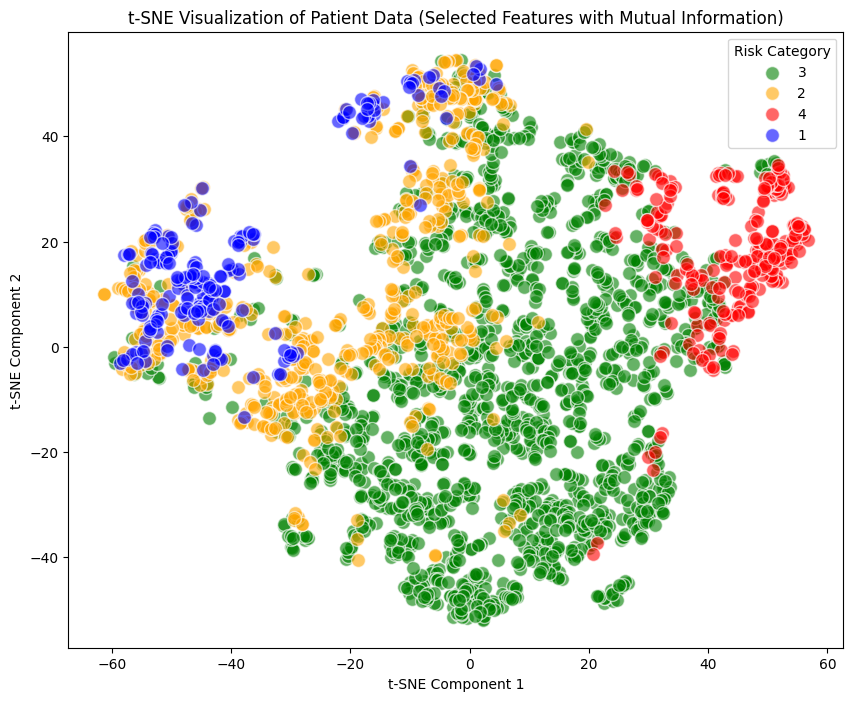

In [314]:
# Plot the t-SNE (for 4 risk categories)
colours = {
    1: "blue",
    2: "orange",
    3: "green",
    4: "red"
}

plt.figure(figsize=(10, 8))
for category in tsne_df['did_not_attend_risk_group'].unique():
    subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, color=colours[category], alpha=0.6, edgecolors='w', s=100)

# Add title and labels
plt.title('t-SNE Visualization of Patient Data (Selected Features with Mutual Information)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend
plt.legend(title='Risk Category')

# Show plot
plt.show()

# Draw out the differences by comparing the selected features

In [315]:
# Create a dataframe with the selected features
selected_data = future_data[selected_features_names]

# Add the risk group column
selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True) 

/var/folders/0t/dc47jt692_qc1qb7bqkgylhw0000gn/T/ipykernel_50063/3671777271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True)


In [317]:
# Group by risk category and summarise: continuous variables
grouped_data_cont = selected_data.drop(["appointment_id", "appt_duration", "reason_display"], axis=1).groupby("did_not_attend_risk_group").agg(["mean", "std"])
grouped_data_cont

age_deid            days_last_appt              \
                                mean        std           mean         std   
did_not_attend_risk_group                                                    
1.0                        44.500000  17.596339     351.596774  460.221880   
2.0                        48.031056  17.962608     387.695652  470.642872   
3.0                        47.877301  19.445839     403.922290  486.404374   
4.0                        47.225352  19.251120     397.380282  486.850472   

                            lead_time            ns_rate_seq            \
                                 mean        std        mean       std   
did_not_attend_risk_group                                                
1.0                        340.629032  43.487414    0.094839  0.055003   
2.0                        340.043478  34.774694    0.100932  0.070903   
3.0                        332.445808  42.176707    0.100225  0.074694   
4.0                        340.126761  24.902627    0.102817  0.072214   

                          osrm_drive_time           past_no_show_rate  \
                                     mean       std              mean   
did_not_attend_risk_group                                               
1.0                              8.992258  4.583413          0.094677   
2.0                              8.265652  3.954188          0.109006   
3.0                              7.834642  3.525512          0.104274   
4.0                              7.561972  3.576642          0.107183   

                                    did_not_attend_risk            
                                std                mean       std  
did_not_attend_risk_group                                          
1.0                        0.156914            0.281164  0.095510  
2.0                        0.207100            0.278080  0.126388  
3.0                        0.198556            0.269732  0.125711  
4.0                        0.195098            0.277123  0.114956

In [319]:
# Group by risk category and summarise: categorical variables
print(selected_data[["reason_display"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())
print()
print(selected_data[["age_deid"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())
print()
print(selected_data[["appt_duration"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

reason_display                    2         1         7
did_not_attend_risk_group                              
1.0                        0.983871  0.016129       NaN
2.0                        0.944099  0.055901       NaN
3.0                        0.952965  0.044990  0.002045
4.0                        0.985915  0.014085       NaN

age_deid                         27        42        52        57        82  \
did_not_attend_risk_group                                                     
1.0                        0.193548  0.145161  0.129032  0.112903  0.080645   
2.0                        0.155280  0.099379  0.086957  0.105590  0.068323   
3.0                        0.161554  0.094070  0.110429  0.087935  0.096115   
4.0                        0.183099  0.098592  0.056338  0.140845  0.084507   

age_deid                         47        32        62        22        17  \
did_not_attend_risk_group                                                     
1.0                        0.0

#### Adding in features selected by the client

In [320]:
# Ethnicity: black
print(historic_data[["ethnic_category_black"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

ethnic_category_black             0         1
did_not_attend_risk_group                    
1                          0.837089  0.162911
2                          0.786380  0.213620
3                          0.760552  0.239448
4                          0.746377  0.253623


In [321]:
# Other vulnerability
print(historic_data[["other_vulnerability"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

other_vulnerability               0         1
did_not_attend_risk_group                    
1                          0.986701  0.013299
2                          0.979627  0.020373
3                          0.969156  0.030844
4                          0.949275  0.050725


In [322]:
# IMD 19 quitile
print(historic_data[["imd19_quintile"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

imd19_quintile                    1         2         3         4         5
did_not_attend_risk_group                                                  
1                          0.207610  0.429996  0.246768  0.100480  0.015146
2                          0.266007  0.452852  0.208382  0.068102  0.004657
3                          0.310065  0.449675  0.185065  0.051948  0.003247
4                          0.355072  0.391304  0.188406  0.057971  0.007246


In [323]:
# Safeguarding
print(historic_data[["safeguarding"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

safeguarding                      0         1
did_not_attend_risk_group                    
1                          0.980421  0.019579
2                          0.946449  0.053551
3                          0.922078  0.077922
4                          0.905797  0.094203


In [324]:
# Substance misuse
print(historic_data[["substance_misuse"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

substance_misuse                  0         1
did_not_attend_risk_group                    
1                          0.994459  0.005541
2                          0.986030  0.013970
3                          0.959416  0.040584
4                          0.949275  0.050725
